In [435]:
# %pip install tensorflow
# %pip install keras

# %pip install --upgrade keras
# %pip install --upgrade keras-cv
# %pip install --upgrade keras-hub
# %pip install --upgrade keras
# %pip install --upgrade typing_extensions


# Config for 1 or 2 Hidden Layers in the Neural Network | True = ON, False = OFF
Layer_ONE                       = True
Layer_TWO                       = True

KFOLD                           = 5     # N-Fold Cross Validation | False can deactivate KFold -> single training
EPOCHS                          = 6     # rounds of training
LEARNING_RATE                   = 0.001 # 0.001 is the default value for Adam Optimizer
BATCH_SIZE                      = 60   # after 128 samples, weights will be updated
SAVE_MODELS_AND_WEIGHTS         = False # Saves all Models&Weights in a folder from each KFold

HiddenLayer_ONE_Neurons         = 32
HiddenLayer_TWO_Neurons         = 16

Output_Neurons                  = 10   # Assuming MNIST digits: 10 output classes

# 0 = sigmoid, 1 = tanh, 2 = relu, 3 = leaky relu, 4 = softmax 
ChooseActivationFunction_ONE    = 0 
ChooseActivationFunction_TWO    = 0 
 
ChooseActivationFunction_OUTPUT = 4 



import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [436]:
if KFOLD:
    (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
else:
    # Load MNIST dataset and split into training and test data.
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    # Verify that the datasets have the expected shapes.
    assert x_train.shape == (60000, 28, 28)  # Input
    assert x_test.shape  == (10000, 28, 28)   # Input
    assert y_train.shape == (60000,)         # Label
    assert y_test.shape  == (10000,)          # Label

# Create a tf.data.Dataset from the training data.
# The images and labels are stored in a dictionary to allow access by keys.
ds = tf.data.Dataset.from_tensor_slices({"image": x_train, "label": y_train})



In [437]:
def Layer_ONE_ACTIVATION(choice):
  if choice == 0:
    return "sigmoid"
  elif choice == 1:
    return "tanh"
  elif choice == 2:
    return "relu"
  elif choice == 3:
    return ""
  elif choice == 4:
    return "softmax"
  else:
    return "sigmoid"

def Layer_TWO_ACTIVATION(choice):
  if choice == 0:
    return "sigmoid"
  elif choice == 1:
    return "tanh"
  elif choice == 2:
    return "relu"
  elif choice == 3:
    return ""
  elif choice == 4:
    return "softmax"
  else:
    return "sigmoid"

def OUTPUT_ACTIVATION(choice):
  if choice == 0:
    return "sigmoid"
  elif choice == 1:
    return "tanh"
  elif choice == 2:
    return "relu"
  elif choice == 3:
    return ""
  elif choice == 4:
    return "softmax"
  else:
    return "sigmoid"


#------------------------------------------------------------------------------
# Model CONFIGURATION
#------------------------------------------------------------------------------
def create_model():
  if Layer_ONE:
    activation_one = Layer_ONE_ACTIVATION(ChooseActivationFunction_ONE)

  if Layer_TWO:
    activation_two = Layer_TWO_ACTIVATION(ChooseActivationFunction_TWO)

  if Output_Neurons: 
    activation_output = OUTPUT_ACTIVATION(ChooseActivationFunction_OUTPUT)


  # Build the model using the chosen activations
  layers = [
    tf.keras.layers.Input(shape=(28, 28, 1)),
    tf.keras.layers.Flatten()
  ]

  if Layer_ONE:
    layers.append(tf.keras.layers.Dense(HiddenLayer_ONE_Neurons, activation=activation_one))

  if Layer_TWO:
    layers.append(tf.keras.layers.Dense(HiddenLayer_TWO_Neurons, activation=activation_two))

  layers.append(tf.keras.layers.Dense(Output_Neurons, activation=activation_output))

  model = tf.keras.Sequential(layers)

  model.compile(
  optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

  return model


if KFOLD:
  print("KFOLD")
  pass

if not KFOLD:
  print("NOT KFOLD")
  model = create_model()
  
  early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',        # Metric to be monitored.
      patience=2,                # Number of epochs to wait for improvement before stopping.
      restore_best_weights=True  # Restore model weights from the epoch with the best monitored metric.
  )

  

KFOLD


In [438]:
if KFOLD:
    kfold = KFold(n_splits=KFOLD, shuffle=True)
    fold_accuracies = []
    histories = []
    i = 0

    for train_idx, val_idx in kfold.split(x_train):
        model = create_model()                              # new model for this run
        early_stop = tf.keras.callbacks.EarlyStopping()     # new early stopping for this run
        
        x_train_fold, x_val_fold = x_train[train_idx]/255.0, x_train[val_idx]/255.0     # normalise the data
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]                 # get the labels

        history = model.fit(
            x_train_fold, y_train_fold,                     # traindata for this fold
            validation_data=(x_val_fold, y_val_fold),       # validation data for this fold
            epochs=EPOCHS,                                  # number of epochs to train
            batch_size=BATCH_SIZE,                          # after how many samples to update the weights
            callbacks=[early_stop]                          # backpropagation with early stopping
        )

  
        histories.append(history)  # Save the history object for later analysis
        
        loss, accuracy = model.evaluate(x_val_fold, y_val_fold) # Evaluate the model on the validation data
        
        fold_accuracies.append(accuracy)

        if SAVE_MODELS_AND_WEIGHTS:
          os.makedirs("Models", exist_ok=True)
          model.save(f"Models/saved_model_{i}.keras")
          model.save_weights(f"Models/saved_weights_{i}.weights.h5")
          i += 1
        
else:
  # Falls KFOLD nicht gesetzt ist (z.B. False oder 0), wird das Modell direkt auf den gesamten Trainingsdaten trainiert.
  history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_test, y_test))
  
  # Nach dem Training erfolgt die Evaluierung des Modells auf den Testdaten.
  loss, accuracy = model.evaluate(x_test, y_test)



Epoch 1/6
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5732 - loss: 1.7610 - val_accuracy: 0.8627 - val_loss: 0.7022
Epoch 2/6
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8788 - loss: 0.5860 - val_accuracy: 0.9087 - val_loss: 0.3847
Epoch 3/6
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9142 - loss: 0.3465 - val_accuracy: 0.9255 - val_loss: 0.2858
Epoch 4/6
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9314 - loss: 0.2626 - val_accuracy: 0.9358 - val_loss: 0.2375
Epoch 5/6
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9422 - loss: 0.2171 - val_accuracy: 0.9403 - val_loss: 0.2099
Epoch 6/6
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9481 - loss: 0.1889 - val_accuracy: 0.9457 - val_loss: 0.1912
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9475 - loss: 0.1884
Epoch 1/6
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5243 - loss: 1.7665 - val_accuracy: 0.8697 - val_loss: 0.6726
Epoch 2/6
800/800 ━━━━━━━━━━━━━━━━━━

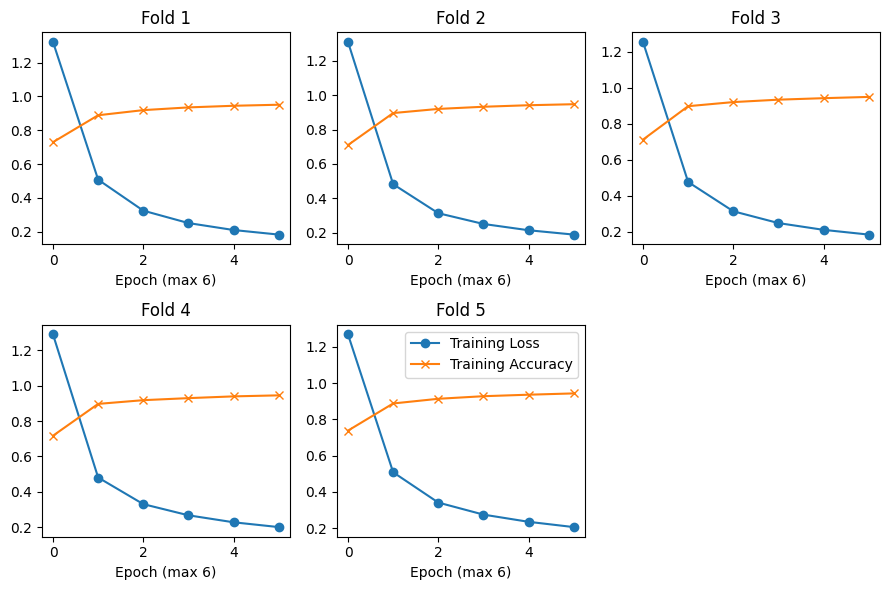

In [439]:

if KFOLD:
    n_folds = len(histories)
    if n_folds >= 5:
        cols = (n_folds + 1) // 2  
        rows = 2
        fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axs = axs.flatten()
    else:
        fig, axs = plt.subplots(1, n_folds, figsize=(n_folds * 3, 3))
        if n_folds == 1:
            axs = [axs]
    
    for i, hist in enumerate(histories):
        ax = axs[i]
        ax.plot(hist.history['loss'], marker='o', label='Training Loss')
        ax.plot(hist.history['accuracy'], marker='x', label='Training Accuracy')
        ax.set_xlabel(f'Epoch (max {EPOCHS})')
        ax.set_title(f'Fold {i+1}')
    
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    ax.legend()
    plt.tight_layout()
    plt.show()
    
else:
    plt.figure(figsize=(3,2))
    plt.plot(history.history['loss'], marker='o', label='Training Loss')
    plt.plot(history.history['accuracy'], marker='x', label='Training Accuracy')
    plt.xlabel(f'Epoch (max {EPOCHS})')
    plt.title('Training Loss and Accuracy')
    plt.legend()
    plt.show()

In [440]:
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display



urls = [
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/2.png?raw=true",
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/1.png?raw=true",
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/3.png?raw=true",
    "https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/4.png?raw=true"
]

# Takes last model from KFold or the model trained on the full dataset
for idx, url in enumerate(urls):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            print(f"Image {idx+1} loaded from: {url}")
            display(img)
            
            # Convert to grayscale and resize to 28x28
            img_proc = img.convert("L").resize((28, 28))
            
            # Prepare the image for the model: normalize and add dimensions
            img_arr = 1.0 - np.array(img_proc) / 255.0
            img_arr = img_arr.reshape(1, 28, 28, 1)
            
            # Get prediction from the model
            probs = model.predict(img_arr)
            pred_class = np.argmax(probs)
            
            print(f"Predicted class: {pred_class}")
            print(f"Probabilities: {probs}")
        else:
            print(f"Failed to load image {idx+1} from: {url} with status code {response.status_code}")
    except Exception as e:
        print(f"Error processing image {idx+1} from {url}: {e}")


Image 1 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/2.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted class: 3
Probabilities: [[0.01211675 0.06416868 0.23916565 0.516948   0.00057846 0.01959283
  0.13805859 0.00596567 0.00082535 0.00258004]]
Image 2 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/1.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class: 1
Probabilities: [[1.3987912e-04 5.4813200e-01 3.9029843e-03 1.2742776e-02 3.2547582e-04
  2.4690495e-03 8.0920866e-04 3.7233621e-01 1.7281430e-02 4.1861054e-02]]
Image 3 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/3.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted class: 3
Probabilities: [[1.4846929e-02 5.1562328e-02 9.2414640e-02 6.5301967e-01 2.5356057e-04
  8.8725932e-02 8.7044083e-02 5.8584106e-03 1.6441660e-03 4.6303682e-03]]
Image 4 loaded from: https://github.com/Nr44suessauer/nr44suessauer.github.io/blob/main/assets/img/DeepLearningTest/4.png?raw=true


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted class: 5
Probabilities: [[0.03053618 0.00450411 0.02368646 0.00929889 0.00309409 0.75413185
  0.07126638 0.0012684  0.09923398 0.00297967]]
